# Analyse des EPOC en Auvergne-Rhône-Alpes
## Mise en place de l'environnement

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from dynaconf import Dynaconf, Validator
import psycopg2
import pickle

In [2]:
# Drapeaux
GET_FROM_DB = False

# Constantes
EPOC_BUFFER = 200

# Variables d'environment
ENVDIR = Path.home() / ".lpo_atlas_stats"  # Project data directory
DATADIR = ENVDIR / "data"  # Directory for resulting csv files (subdir of ENVDIR)
RESULTDIR = ENVDIR / "result"  # Directory for resulting csv files (subdir of ENVDIR)
CONFIG = ENVDIR / "lpo_aura.toml"  # Configuration file

# Lecture des paramètres de configuration
_settings = Dynaconf(
    settings_files=[CONFIG],
    validators=[
            Validator('db.db_host', must_exist=True),
            Validator('db.db_port', must_exist=True, gt=0),
            Validator('db.db_user', must_exist=True),
            Validator('db.db_password', must_exist=True),
            Validator('db.db_name', must_exist=True),
            Validator('db.db_schema', must_exist=True),
            Validator('sig.departments', must_exist=True),
            Validator('sig.clc', must_exist=True),
            Validator('sig.nom_clc', must_exist=True),
    ]
)

In [3]:
# Lecture du contour des départements
dept = gpd.read_file(DATADIR / _settings.sig.departments).drop(["ID", "NOM_DEP_M"], axis="columns")
dept_aura = dept[dept["INSEE_REG"] == "84"].copy()
dept_aura.set_index('INSEE_DEP', inplace=True)
dept_aura.sort_index(inplace=True)
dept_aura['area'] = dept_aura.area
#dept_aura

In [4]:
# Lecture de Corine Land Cover
clc = gpd.read_file(DATADIR / _settings.sig.clc)
#clc.head()
#clc.plot();

In [5]:
clc_nom = pd.read_csv(DATADIR / _settings.sig.nom_clc, sep=";", usecols=["code_clc_niveau_3", "libelle_fr"]).rename(columns={"code_clc_niveau_3": "CODE_18"}).set_index("CODE_18")

## Simulation d'EPOC pour analyser la couverture spatiale

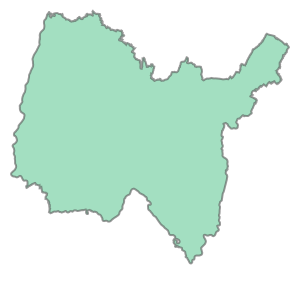

In [60]:
dept_aura.iloc[0]["geometry"]

In [59]:
reg_aura = gpd.GeoDataFrame()
for d in range(len(dept_aura)):
    reg_aura = gpd.overlay(reg_aura, gpd.GeoDataFrame(crs="EPSG:2154", dept_aura.iloc[d]["geometry"]), how="union")
reg_aura.plot()  

ValueError: DataFrame constructor not properly called!

In [50]:
bounds_aura = dept_aura["geometry"].bounds
nb_sim = 500
points_aura = gpd.GeoSeries(crs="EPSG:2154")
for d in range(len(dept_aura)):
    x_min, y_min, x_max, y_max = bounds_aura.iloc[d]
    area = dept_aura['area'].iloc[d]
    nb_cible = int(nb_sim*area/10e9)
    #print(dept_aura['NOM_DEP'].iloc[d], area, nb_cible)
    x = np.random.uniform(x_min, x_max, int(nb_cible*2.5))
    y = np.random.uniform(y_min, y_max, int(nb_cible*2.5))
    rand_points = gpd.GeoSeries(crs="EPSG:2154", data=gpd.points_from_xy(x, y))
    dept_points = rand_points[rand_points.within(dept_aura["geometry"].iloc[d])].iloc[0:nb_cible]
    print(dept_aura['NOM_DEP'].iloc[d], len(dept_points))
    points_aura = points_aura.append(dept_points)

points_aura = gpd.GeoDataFrame({'geometry':points_aura}, crs="EPSG:2154")
#print(points_aura)
# Buffer and merge simulated EPOCs
points_aura["geometry"] = points_aura.buffer(EPOC_BUFFER)
sim_union = gpd.GeoDataFrame(crs="EPSG:2154", geometry=[points_aura.unary_union])
#base = dept_aura.plot(column='NOM_DEP', categorical=True, cmap='Blues')
#sim_union.plot(ax=base, color='red');
# Classify simulated EPOC surface by department
sim_dept = gpd.overlay(dept_aura, sim_union, how='intersection')
sim_dept['epoc_area'] = sim_dept.area
sim_dept.head()
sim_dept['epoc_pct'] = sim_dept['epoc_area']/sim_dept['area']*100
sim_dept[['NOM_DEP', 'epoc_pct']]
#sns.barplot(y="NOM_DEP", x="epoc_pct", palette="Greens", data=sim_dept.sort_values(['epoc_pct']).reset_index(drop=True));

Ain 288
Allier 368
Ardèche 278
Cantal 288
Drôme 327
Isère 393
Loire 239
Haute-Loire 249
Puy-de-Dôme 400
Rhône 162
Savoie 313
Haute-Savoie 229


NOM_DEP  epoc_pct
0            Ain  0.625486
1         Allier  0.623492
2        Ardèche  0.626287
3         Cantal  0.623272
4          Drôme  0.623588
5          Isère  0.625580
6          Loire  0.626383
7    Haute-Loire  0.625021
8    Puy-de-Dôme  0.616793
9          Rhône  0.620374
10        Savoie  0.623529
11  Haute-Savoie  0.620434